In [1]:
# Set the working directory, change to your specific directory
import os
os.chdir('/Your_project_folder')

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
from models.networks import get_model
from data_utils.data_stats import *
import matplotlib.pyplot as plt
import numpy as np
import os

/Users/charleslego/opt/anaconda3/envs/DL_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- list of altered datasets -------
altered_datasets = ['cifar10_permuted_block_size_8.pth', 'cifar10_permuted_block_size_16.pth', 'cifar10_FGSM_MLP.pth', 'cifar10_FGSM_VGG13.pth', 'cifar10_FGSM_resnet50.pth', 'cifar10_FGSM_densenet169.pth']

# select the altered dataset you want to evaluate your model on
altered_dataset = altered_datasets[0]
folder_path = './cifar10_datasets/'
dataset_path = os.path.join(folder_path, altered_dataset)

# ---------- Load the CIFAR-10 test dataset -------------

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

#--------- Load the permuted dataset ----------

class CustomDataset(Dataset):
    def __init__(self, dataset_dict, transform = None):
        self.dataset_dict = dataset_dict
        self.transform = transform

    def __len__(self):
        return len(self.dataset_dict)

    def __getitem__(self, index):
        data = self.dataset_dict[index]
        image = data['image']
        if self.transform:
            image = self.transform(data['image'])
        label = data['label']

        return image, label

# Load the dataset dictionary
loaded_dataset = torch.load(dataset_path)

# Create an instance of the CustomDataset
permuted_dataset = CustomDataset(loaded_dataset, transform = transform)
permuted_loader = DataLoader(permuted_dataset, batch_size=1024, shuffle=False)


# ------------- Load the pretrained model ------------

dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10


pretrained_model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=CLASS_DICT[dataset],
                  checkpoint='in21k_cifar10')
pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

# -----------calculate accuracies -----------

def accuracy_calc(loader, classes, dataset):
    num_classes = len(classes)
    # Initialize a dictionary to store per-class counts
    class_counts = {class_idx: {'correct': 0, 'total': 0} for class_idx in range(num_classes)}

    with torch.no_grad():
        for inputs, labels in loader:

            inputs = torch.reshape(inputs, (inputs.shape[0], -1))
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = pretrained_model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Update counts for each class
            for class_idx in range(num_classes):
                class_mask = labels == class_idx
                class_total = class_mask.sum().item()
                class_correct = (predicted[class_mask] == class_idx).sum().item()

                class_counts[class_idx]['correct'] += class_correct
                class_counts[class_idx]['total'] += class_total

    # Calculate per-class accuracy
    per_class_accuracy = {class_idx: class_counts[class_idx]['correct'] / class_counts[class_idx]['total']
                        for class_idx in range(num_classes)}

    # Print per-class accuracy
    total_accuracy = 0
    for class_idx in range(num_classes):
        print(f'{dataset} accuracy for {classes[class_idx]}: {100 * per_class_accuracy[class_idx]:.2f}%') # 
        total_accuracy += per_class_accuracy[class_idx]

    print(f'{dataset} total accuracy : {100 * total_accuracy/10:.2f}%')

classes  = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
accuracy_calc(test_loader, classes, 'CIFAR10')
accuracy_calc(permuted_loader, classes, 'Altered CIFAR10')



Files already downloaded and verified
Weights already downloaded
Load_state output <All keys matched successfully>


/Users/charleslego/opt/anaconda3/envs/DL_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


CIFAR10 accuracy for Airplane: 96.20%
CIFAR10 accuracy for Car: 94.60%
CIFAR10 accuracy for Bird: 94.80%
CIFAR10 accuracy for Cat: 86.80%
CIFAR10 accuracy for Deer: 96.10%
CIFAR10 accuracy for Dog: 88.20%
CIFAR10 accuracy for Frog: 95.90%
CIFAR10 accuracy for Horse: 95.20%
CIFAR10 accuracy for Ship: 96.60%
CIFAR10 accuracy for Truck: 96.50%
CIFAR10 total accuracy : 94.09%
Altered CIFAR10 accuracy for Airplane: 76.60%
Altered CIFAR10 accuracy for Car: 78.90%
Altered CIFAR10 accuracy for Bird: 75.90%
Altered CIFAR10 accuracy for Cat: 68.00%
Altered CIFAR10 accuracy for Deer: 69.90%
Altered CIFAR10 accuracy for Dog: 60.10%
Altered CIFAR10 accuracy for Frog: 75.80%
Altered CIFAR10 accuracy for Horse: 71.00%
Altered CIFAR10 accuracy for Ship: 83.00%
Altered CIFAR10 accuracy for Truck: 74.80%
Altered CIFAR10 total accuracy : 73.40%


Visualize the altered datasets

Files already downloaded and verified


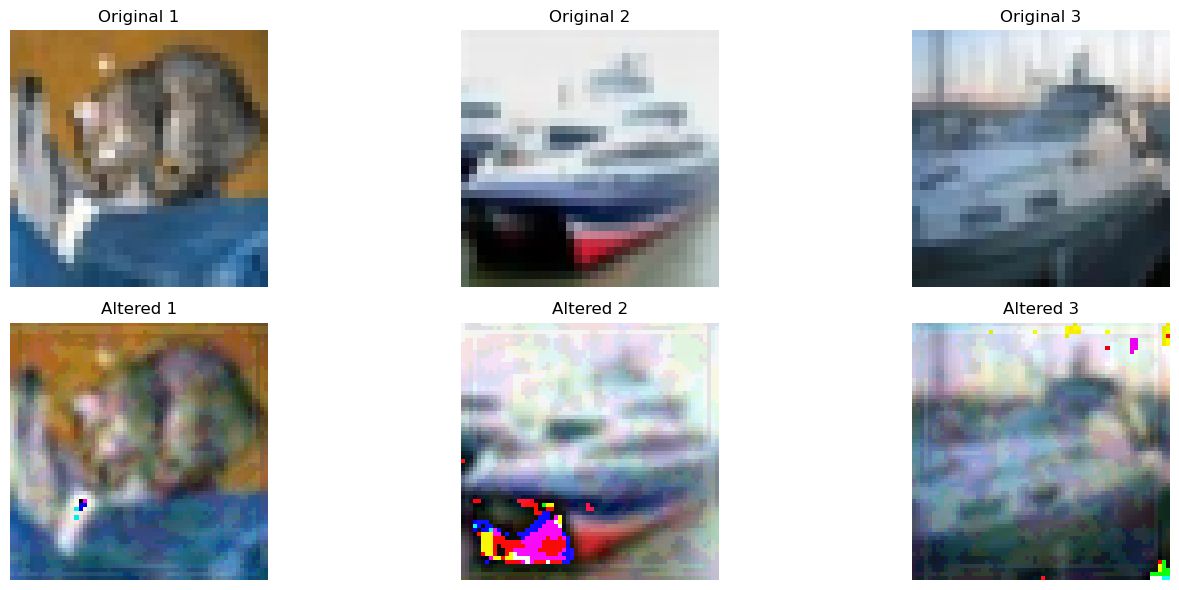

In [4]:
# -------- list of altered datasets -------
altered_datasets = ['cifar10_FGSM_MLP.pth', 'cifar10_FGSM_VGG13.pth', 'cifar10_FGSM_resnet50.pth', 'cifar10_FGSM_densenet169.pth']


# Original dataset
original_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

# select the altered dataset you want to visualize
altered_dataset = altered_datasets[0]
folder_path = './cifar10_datasets/'
dataset_path = os.path.join(folder_path, altered_dataset)

loaded_dataset = torch.load(dataset_path)
altered_dataset = CustomDataset(loaded_dataset, transform = None)


# Create a subplot for each image
fig, axes = plt.subplots(2, 3, figsize=(15, 6))

for i in range(3):
    # Original image
    original_image, _ = original_dataset[i]
    axes[0, i].imshow(np.array(original_image))
    axes[0, i].set_title(f'Original {i + 1}')

    # Altered image
    altered_image, _ = altered_dataset[i]
    axes[1, i].imshow(np.array(altered_image))
    axes[1, i].set_title(f'Altered {i + 1}')

# Hide the axes
for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()
